In [52]:
import torch
import matplotlib.pyplot as plt
import collections

In [97]:
# Fetch all names from the file
names = []
with open("names.txt") as file:
    for line in file.read().splitlines():
        names.append(line)

print(f"no of names in the file are {len(names)}")


no of names in the file are 32033


In [122]:
# String to Integer with Start <S> and End <End>
chars = sorted(set(''.join(names)))
stoi = {char: i+1 for i,char in enumerate(chars)}
stoi['<S>'] = 0
stoi['<E>'] = 27
print(f"{stoi=}")
itos = {i: char for char, i in stoi.items()}
print(f"{itos=}")

stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '<S>': 0, '<E>': 27}
itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '<S>', 27: '<E>'}


In [123]:
# Generate Bigrams
N_with_start_and_end = torch.zeros((28, 28), dtype=torch.int32)
for name in names:
  chs = ['<S>'] + list(name) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
      i1 = stoi[ch1]
      i2 = stoi[ch2]
      N_with_start_and_end[i1, i2] +=1

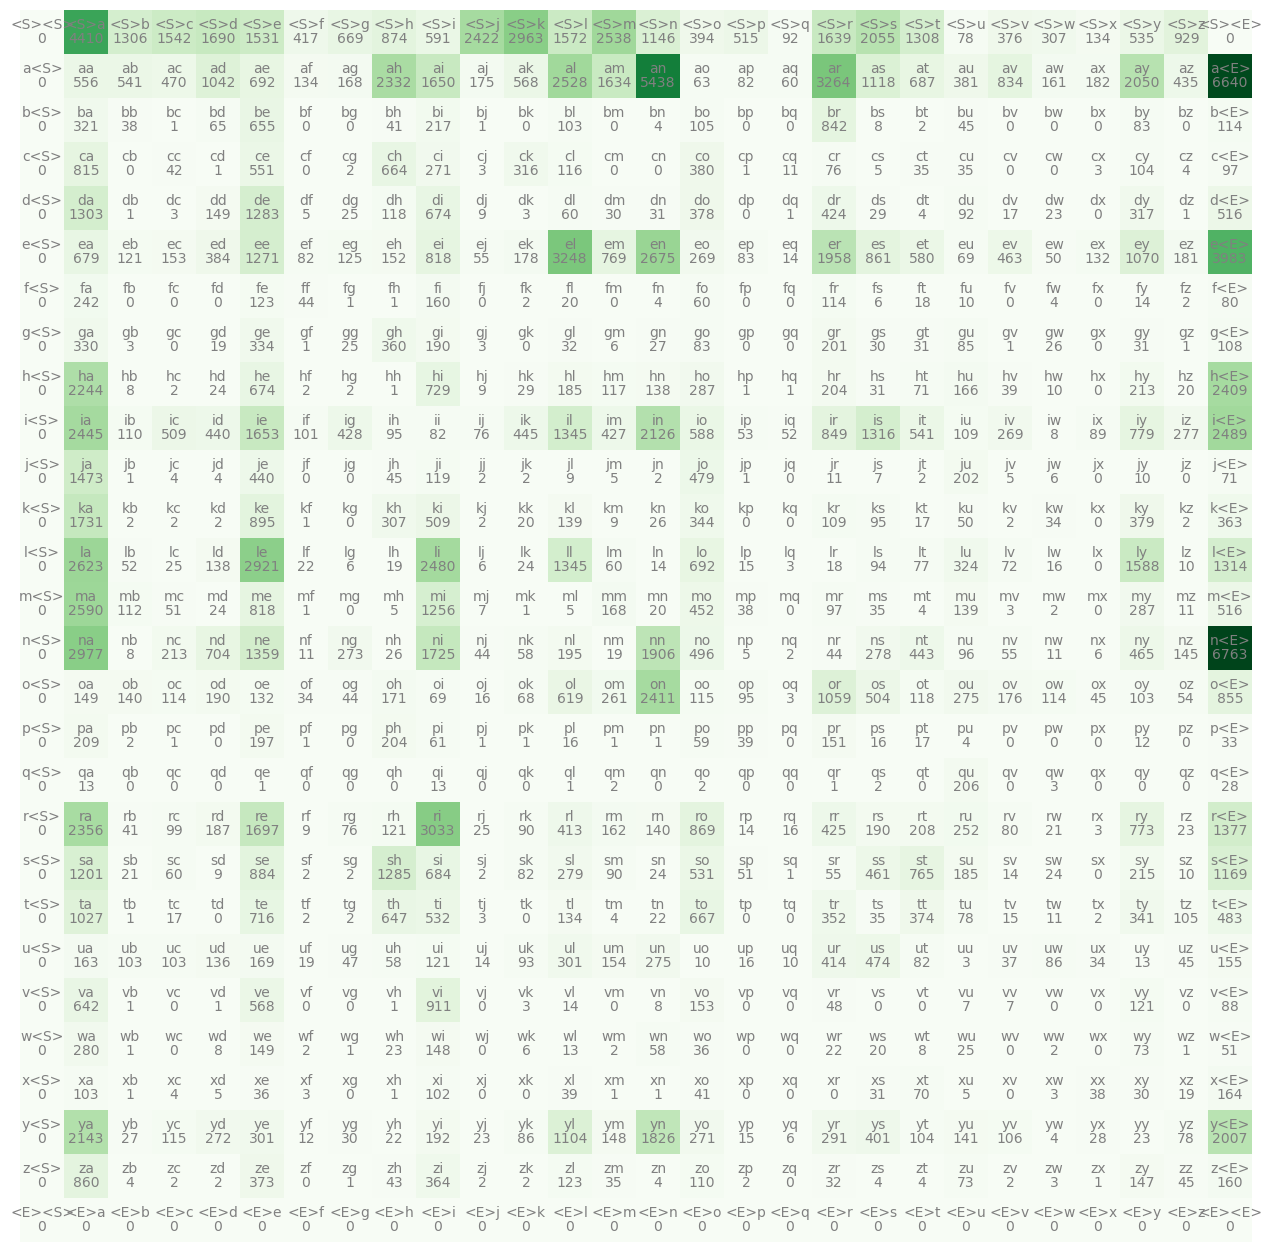

In [124]:
plt.figure(figsize=(16,16))
plt.imshow(N_with_start_and_end, cmap='Greens')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N_with_start_and_end[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

As we can see that <S> can never come at the end and <E> can never start, we are wasting some space. To mitigate that we just need one special char, let's go with .

In [129]:
N = torch.zeros(27,27, dtype=torch.int32)

In [130]:
chars = sorted(set('.'.join(names)))
stoi = {char: i for i,char in enumerate(chars)}
print(f"{stoi=}")
itos = {i: char for char, i in stoi.items()}
print(f"{itso=}")

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itso={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [131]:
for name in names:
  chs = ['.'] + list(name) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

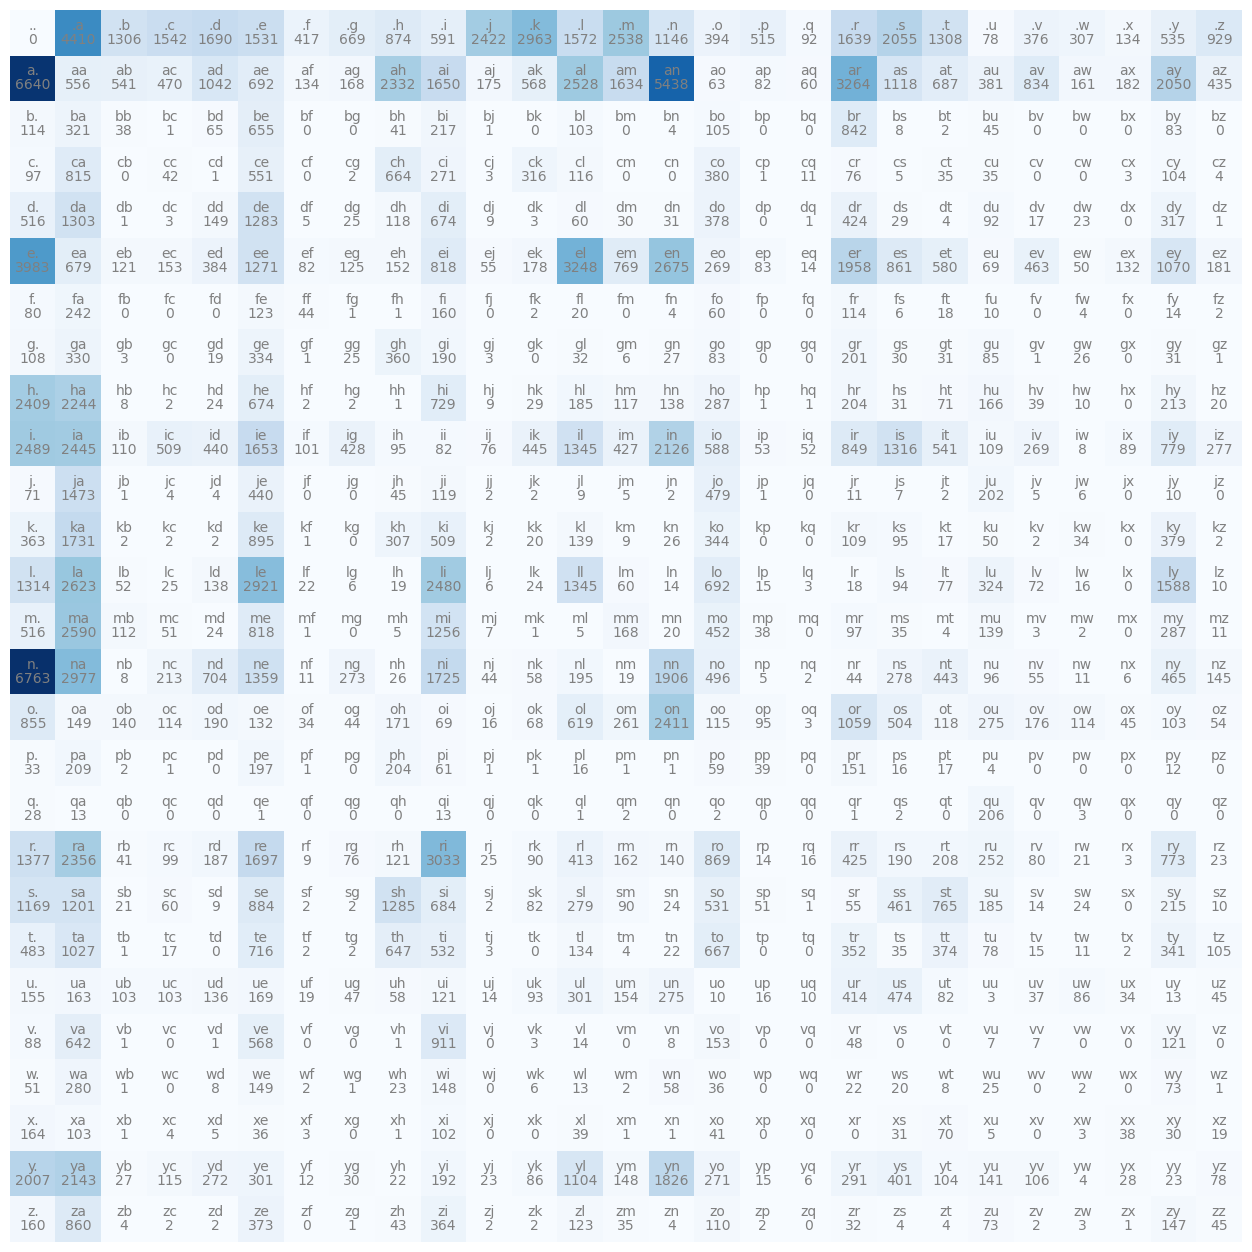

In [132]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [140]:
prob_of_each_letter_to_start_the_name = N[0]/N[0].sum()
print(f"{prob_of_each_letter_to_start_the_name=}")
prob_of_each_letter_to_start_the_name.shape

prob_of_each_letter_to_start_the_name=tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


torch.Size([27])

In [155]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(prob_of_each_letter_to_start_the_name, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [152]:
def generate_names(P, n=5):
    g = torch.Generator().manual_seed(2147483647)
    for i in range(n):
      out = []
      ix = 0
      while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
          break
      print(''.join(out))

In [153]:
P = N/N.sum(1, keepdims=True)
generate_names(P)

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


In [154]:
# let's try some smoothing
P = (N+1).float()/N.sum(1, keepdims=True)
generate_names(P)

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


In [157]:
# Finding Performance of the model 
log_likelihood = 0.0
n = 0

for name in names:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559322.6875)
nll=tensor(559322.6875)
2.4515998363494873
